In [109]:
import qiskit_nature
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import Psi4Driver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper
qiskit_nature.settings.use_pauli_sum_op = False


def qubit_operator(dist):
    mol = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,
        charge=0,
    )

    problem = Psi4Driver.from_molecule(mol).run()

    spatial_orbitals_count = problem.num_spatial_orbitals
    particle_count = problem.num_particles

    mapper = ParityMapper(num_particles=particle_count)  # Set Mapper

    hamiltonian = mapper.map(problem.second_q_ops()[0])  # Set Hamiltonian

    return hamiltonian, particle_count, spatial_orbitals_count, problem, mapper

In [110]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver

def exact_sol(hamiltonian):
    exact_solver = NumPyEigensolver(k=4)
    exact_result = exact_solver.compute_eigenvalues(hamiltonian)
    return exact_result.eigenvalues
    '''
    print(exact_result)
    result = []
    for x in exact_result:
        result.append(problem.interpret(x).total_energies[0].real)
    return result
    '''

In [111]:
from qiskit.algorithms.optimizers import SLSQP
optimizer = SLSQP(maxiter=150, max_evals_grouped=1)

In [112]:
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute

estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

ComputeUnCompute uses the sampler primitive to calculate the state fidelity of two quantum circuits following the compute-uncompute method

fedility (state overlap): <img src=images/cuc_sol.png />

The initial release of Qiskit Runtime includes two primitives:

Sampler: Generates quasi-probability distribution from input circuits.

Estimator: Calculates expectation values from input circuits and observables.

In [113]:
k = 4
betas = [33, 33, 33, 33]

<img src=images/vqd_cost.png>

In [115]:
from qiskit.algorithms.eigensolvers import VQD
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
import numpy as np

exact_energies = []
vqd_energies = []

for i in np.arange(0.1, 2.5, 0.1):
    get_op = qubit_operator(i)

    init_state = HartreeFock(get_op[2], get_op[1], get_op[4])
    ansatz = UCCSD(
        get_op[2], get_op[1], get_op[4], initial_state=init_state
    )

    vqd = VQD(estimator, fidelity, ansatz, optimizer, k=k, betas=betas)
    result = vqd.compute_eigenvalues(operator = get_op[0])
    '''
    vqd_result = get_op[3].interpret(vde_calc).total_energies[0].real
    vqd_energies.append(vqe_result)
    '''
    vqd_energies.append(result.eigenvalues)
    exact_energies.append(exact_sol(get_op[0]))

In [ ]:
exact_arr = np.array(exact_energies)
vqd_arr = np.array(vqd_energies)

import numpy as np
import matplotlib.pyplot as plt
g1=plt

g1.rcParams["figure.figsize"] = (12, 8)

_counts = np.arange(0.1, 2.5, 0.1)
for i in range(0,4):
    _values = vqd_arr[:,i]
    _actual = exact_arr[:,i]
    g1.plot(_counts[0:19], _values[0:19], label=f"State {i}")
    g1.plot(_counts, _actual, linestyle='dashed', label=f'{i}')
    

g1.xlabel("Eval count")
g1.ylabel("Energy")
g1.title("Energy convergence for each computed state")
g1.legend(loc="upper right")
g1.show()

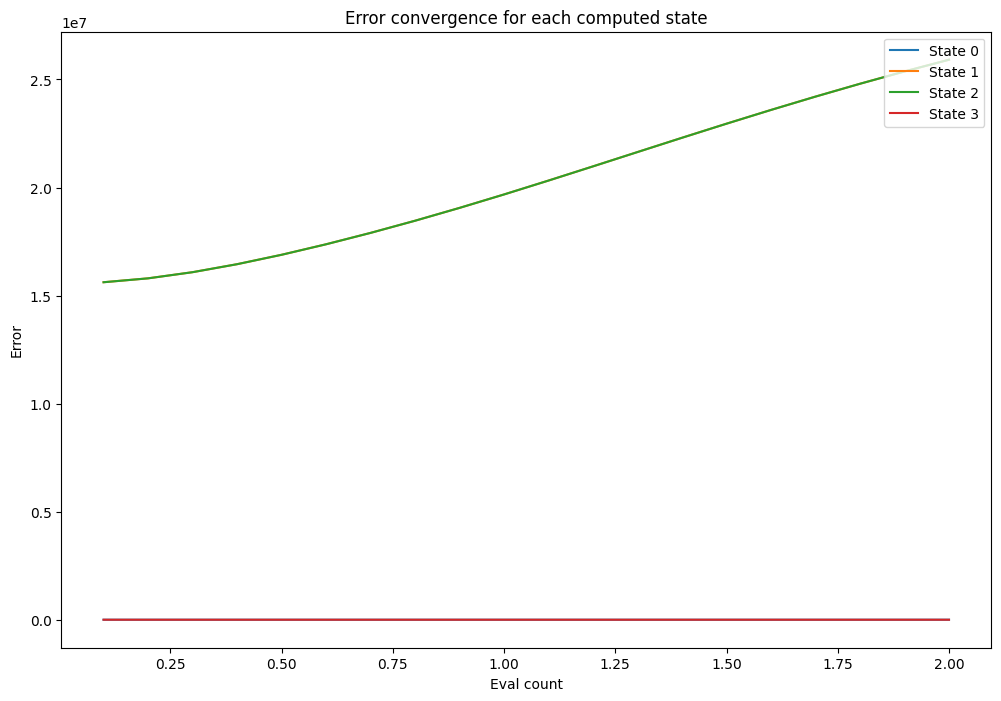

In [130]:
import numpy as np
import matplotlib.pyplot as plt

g2 = plt
g2.rcParams["figure.figsize"] = (12, 8)

_counts = np.arange(0.1, 2.5, 0.1)
for i in range(0,4):
    _values = vqd_arr[:,i]
    _actual = exact_arr[:,i]
    g2.plot(_counts[0:20], (abs(_values-_actual)*10**8)[0:20], label=f"State {i}")

g2.xlabel("Eval count")
g2.ylabel("Error")
g2.title("Error convergence for each computed state")
g2.legend(loc="upper right")
g2.show()